In [1]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to c:\users\alpka\appdata\local\temp\pip-req-build-_j9e9v1a
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 0d53acbcf5123d4c88040fe68fbb9805fc5b2fb9
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started


  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git 'C:\Users\alpka\AppData\Local\Temp\pip-req-build-_j9e9v1a'


  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for pydensecrf: filename=pydensecrf-1.0rc2-cp39-cp39-win_amd64.whl size=191753 sha256=d00a769746a79a9d95b58e9f43df0225cc15f70041fc6dd2003152c06c7ba521
  Stored in directory: C:\Users\alpka\AppData\Local\Temp\pip-ephem-wheel-cache-lq04u62j\wheels\85\f3\c8\23357c17441e63dc03cf2e29bc03056d386accb87f9408b49a
Successfully built pydensecrf


In [2]:
from IPython.display import clear_output

!pip install -q tensorflow==2.4.1

clear_output()

In [3]:
import os
import numpy as np
import pandas as pd
from glob import glob
import random

import cv2
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.data import Dataset
from tensorflow.keras import layers
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

import pydensecrf.densecrf as dcrf
# Setting seeds for reproducibility.
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [5]:
gpus = tf.config.list_physical_devices(device_type='GPU')
tf.config.set_visible_devices(gpus, device_type='GPU')

In [6]:
IMAGE_DIR = '../semantic/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images'
MASK_DIR = '../semantic/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic'
BATCH_SIZE=4
EPOCHS=10
LR = 1e-4
HEIGHT = 512
WIDTH = 512

In [8]:
sample_mask = cv2.imread('../semantic/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/000.png',cv2.IMREAD_GRAYSCALE)
num_classes = np.max(sample_mask) + 1
height = sample_mask.shape[0]
width = sample_mask.shape[1]
print('the number of total classes: ', num_classes)
print('sample image height {}, width {}'.format(height, width))

the number of total classes:  23
sample image height 4000, width 6000


In [9]:
image_paths = glob(os.path.join(IMAGE_DIR, '*.jpg'))
image_paths.sort()
mask_paths = glob(os.path.join(MASK_DIR, '*.png'))
mask_paths.sort()
print('total number of images: ', len(image_paths))

total number of images:  400


In [10]:
data = pd.DataFrame(np.array([image_paths, mask_paths]).T, columns=['image','mask'])
print(data.iloc[0,0])
print(data.iloc[0,1])

../semantic/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images\000.jpg
../semantic/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic\000.png


In [11]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(image_paths, mask_paths, test_size=0.1, random_state=19)
print('total number of images in training set: ', len(train_x))
print('total number of images in testing set: ', len(test_x))

total number of images in training set:  360
total number of images in testing set:  40


In [12]:
def read_image(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    image = image / 255.0
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [HEIGHT, WIDTH])
    mask = tf.cast(tf.squeeze(mask), dtype=tf.int32)
    mask = tf.one_hot(mask, num_classes, dtype=tf.int32)
    return image, mask

def augment_image_batch1(image, mask):
    new_seed = np.random.randint(100)
    print(image.shape)
    print(mask.shape)
    image = tf.image.resize(image, [int(1.2 * HEIGHT), int(1.2 * WIDTH)])
    mask = tf.image.resize(mask, [int(1.2 * HEIGHT), int(1.2 * WIDTH)])
    image = tf.image.random_crop(image, (HEIGHT, WIDTH, 3), seed=new_seed)
    mask = tf.image.random_crop(mask, (HEIGHT, WIDTH, num_classes), seed=new_seed)
    image = tf.image.random_flip_left_right(image, seed=new_seed)
    mask = tf.image.random_flip_left_right(mask, seed=new_seed)
    mask = tf.cast(mask, dtype=tf.int32)
    return image,mask

def augment_image_batch2(image, mask):
    new_seed = np.random.randint(100)
    image = tf.image.resize(image, [int(1.2 * HEIGHT), int(1.2 * WIDTH)])
    mask = tf.image.resize(mask, [int(1.2 * HEIGHT), int(1.2 * WIDTH)])
    image = tf.image.random_crop(image, (HEIGHT, WIDTH, 3), seed=new_seed)
    mask = tf.image.random_crop(mask, (HEIGHT, WIDTH, num_classes), seed=new_seed)
    image = tf.image.random_flip_up_down(image, seed=new_seed)
    mask = tf.image.random_flip_up_down(mask, seed=new_seed)
    mask = tf.cast(mask, dtype=tf.int32)
    return image,mask

In [13]:
train_ds = Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.map(read_image)
train_ds1 = train_ds.map(augment_image_batch1)
train_ds2 = train_ds.map(augment_image_batch2)
train_ds = train_ds.concatenate(train_ds1.concatenate(train_ds2))
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(True)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

test_ds = Dataset.from_tensor_slices((test_x, test_y))
test_ds = test_ds.map(read_image)
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

(512, 512, 3)
(512, 512, 23)


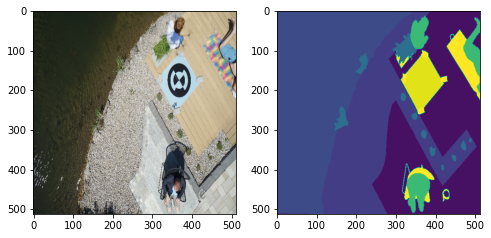

In [14]:
fg, ax = plt.subplots(1,2, figsize=(8,16))
for image, mask in test_ds.take(1):
    ax[0].imshow(image[1,...])
    ax[1].imshow(tf.argmax(mask[1,...],axis=-1))

clear_output()

In [15]:
# ## mobile net backbone unet
# def get_upsampling_block(inp, channels):
#     inp = layers.Conv2DTranspose(channels, (2,2), strides=(2,2), padding='same')(inp)
#     return inp
    
# def get_conv_block(inp, channels):
#     inp = layers.Conv2D(channels, (3, 3), kernel_initializer='he_normal', padding='same')(inp)
#     inp = layers.BatchNormalization()(inp)
#     inp = layers.Activation('gelu')(inp)
#     inp = layers.Conv2D(channels, (3, 3), kernel_initializer='he_normal', padding='same')(inp)
#     inp = layers.BatchNormalization()(inp)
#     inp = layers.Activation('gelu')(inp)
#     return inp

# def get_unet_model(input_shape):
#     base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
#     inp = base_model.input
#     # shape(256,256,96)
#     s1 = base_model.get_layer('expanded_conv_depthwise_relu').output
#     # shape(128,128,144)
#     s2 = base_model.get_layer('block_1_depthwise_relu').output
#     # shape(64,64,192)
#     s3 = base_model.get_layer('block_4_depthwise_relu').output
#     # shape(32,32,576)
#     d = base_model.get_layer('block_6_depthwise_relu').output
    
#     d1 = get_upsampling_block(d, 256)
#     d1 = layers.concatenate([d1, s3])
#     d1 = get_conv_block(d1, 256)
    
#     d2 = get_upsampling_block(d1, 128)
#     d2 = layers.concatenate([d2, s2])
#     d2 = get_conv_block(d2, 128)
    
#     d3 = get_upsampling_block(d2, 64)
#     d3 = layers.concatenate([d3, s1])
#     d3 = get_conv_block(d3, 64)
    
#     output = get_upsampling_block(d3, 32)
#     output = layers.concatenate([output, inp])
#     output = get_conv_block(output, 32)
    
#     output = layers.Conv2D(num_classes, 1, padding='same')(output)
#     output = layers.Softmax(axis=-1)(output)
#     return keras.Model(inp, output)

# tf.keras.backend.clear_session()
# model = get_unet_model((512,512,3))
# model.summary()

In [16]:
### swin-unet
!pip install keras-unet-collection -q -U
from keras_unet_collection import models, losses

In [17]:
tf.keras.backend.clear_session()
model = models.swin_unet_2d((512, 512, 3), filter_num_begin=32,
                               n_labels=num_classes, depth=4, stack_num_down=2, stack_num_up=2,
                               patch_size=(4, 4), num_heads=[4, 8, 8, 8],
                               window_size=[4, 2, 2, 2], num_mlp=156, 
                               output_activation='Softmax', shift_window=True,
                               name='swin_unet')
print(model.summary())

Model: "swin_unet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 patch_extract (patch_extract)  (None, 16384, 48)    0           ['input_1[0][0]']                
                                                                                                  
 patch_embedding (patch_embeddi  (None, 16384, 32)   525856      ['patch_extract[0][0]']          
 ng)                                                                                              
                                                                                    

 swin_unet_concat_linear_proj_2  (None, 16384, 32)   2048        ['swin_unet_concat_2[0][0]']     
  (Dense)                                                                                         
                                                                                                  
 swin_transformer_block_12 (Swi  (None, 16384, 32)   14612       ['swin_unet_concat_linear_proj_2[
 nTransformerBlock)                                              0][0]']                          
                                                                                                  
 swin_transformer_block_13 (Swi  (None, 16384, 32)   80148       ['swin_transformer_block_12[0][0]
 nTransformerBlock)                                              ']                               
                                                                                                  
 patch_expanding_3 (patch_expan  (None, 512, 512, 8)  4096       ['swin_transformer_block_13[0][0]
 ding)    

In [18]:
# def multi_unet_model(n_classes=23, IMG_HEIGHT=512, IMG_WIDTH=512, IMG_CHANNELS=3):
# #Build the model
#     inputs = layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#     s = inputs

#     #Contraction path
#     c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
#     c1 = layers.Dropout(0.1)(c1)  # Original 0.1
#     c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
#     p1 = layers.MaxPooling2D((2, 2))(c1)
    
#     c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
#     c2 = layers.Dropout(0.1)(c2)  # Original 0.1
#     c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
#     p2 = layers.MaxPooling2D((2, 2))(c2)
     
#     c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
#     c3 = layers.Dropout(0.1)(c3)
#     c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
#     p3 = layers.MaxPooling2D((2, 2))(c3)
     
#     c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
#     c4 = layers.Dropout(0.1)(c4)
#     c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
#     p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)
     
#     c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
#     c5 = layers.Dropout(0.3)(c5)
#     c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
#     #Expansive path 
#     u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
#     u6 = layers.concatenate([u6, c4])
#     c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
#     c6 = layers.Dropout(0.1)(c6)
#     c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
#     u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
#     u7 = layers.concatenate([u7, c3])
#     c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
#     c7 = layers.Dropout(0.2)(c7)
#     c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
#     u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
#     u8 = layers.concatenate([u8, c2])
#     c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
#     c8 = layers.Dropout(0.1)(c8)  # Original 0.1
#     c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
#     u9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
#     u9 = layers.concatenate([u9, c1], axis=3)
#     c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
#     c9 = layers.Dropout(0.1)(c9)  # Original 0.1
#     c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
#     outputs = layers.Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
#     model = keras.Model(inputs=[inputs], outputs=[outputs])
    
#     #NOTE: Compile the model in the main program to make it easy to test with various loss functions
#     model.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])
    
#     model.summary()
    
#     return model


# tf.keras.backend.clear_session()
# model = multi_unet_model()

In [19]:
tf.config.experimental_run_functions_eagerly(True)
def focal_loss(predict, true):
    error = keras.losses.categorical_crossentropy(predict, true)
    pt = tf.exp(-error)
    focal_loss = (1 - pt) ** 2 * error
    return tf.reduce_mean(focal_loss)

def mean_iou(predict, true):
    predict = tf.argmax(predict, axis=-1)
    true = tf.argmax(true, axis=-1)
    return keras.metrics.MeanIoU(num_classes=num_classes)(predict, true)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [20]:
model.compile(optimizer='adam',
             loss=focal_loss,
             metrics=['accuracy', mean_iou])

In [21]:
history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS)

Epoch 1/10
270/270 [==============================] - 1751s 6s/step - loss: 1.4469 - accuracy: 0.4829 - mean_iou: 0.0489 - val_loss: 1.0558 - val_accuracy: 0.5676 - val_mean_iou: 0.0669
Epoch 2/10
270/270 [==============================] - 1751s 6s/step - loss: 0.9169 - accuracy: 0.5849 - mean_iou: 0.0862 - val_loss: 0.8579 - val_accuracy: 0.5989 - val_mean_iou: 0.1006
Epoch 3/10
270/270 [==============================] - 1862s 7s/step - loss: 0.7716 - accuracy: 0.6365 - mean_iou: 0.1169 - val_loss: 0.8284 - val_accuracy: 0.6345 - val_mean_iou: 0.1123
Epoch 4/10
270/270 [==============================] - 2064s 8s/step - loss: 0.6954 - accuracy: 0.6627 - mean_iou: 0.1355 - val_loss: 0.8258 - val_accuracy: 0.6354 - val_mean_iou: 0.1280
Epoch 5/10
270/270 [==============================] - 2027s 8s/step - loss: 0.6222 - accuracy: 0.6873 - mean_iou: 0.1529 - val_loss: 0.6515 - val_accuracy: 0.6976 - val_mean_iou: 0.1504
Epoch 6/10
270/270 [==============================] - 1836s 7s/step - 

In [22]:
model.save("version2.h5")

In [23]:
for images, masks in test_ds.take(1):
    pred = model.predict(images)

C:\Users\alpka\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 2s 2s/step


In [24]:
predictions = np.argmax(pred, axis=-1)
labels = np.argmax(masks, axis=-1)
print(labels.shape)
print(predictions.shape)

(4, 512, 512)
(4, 512, 512)


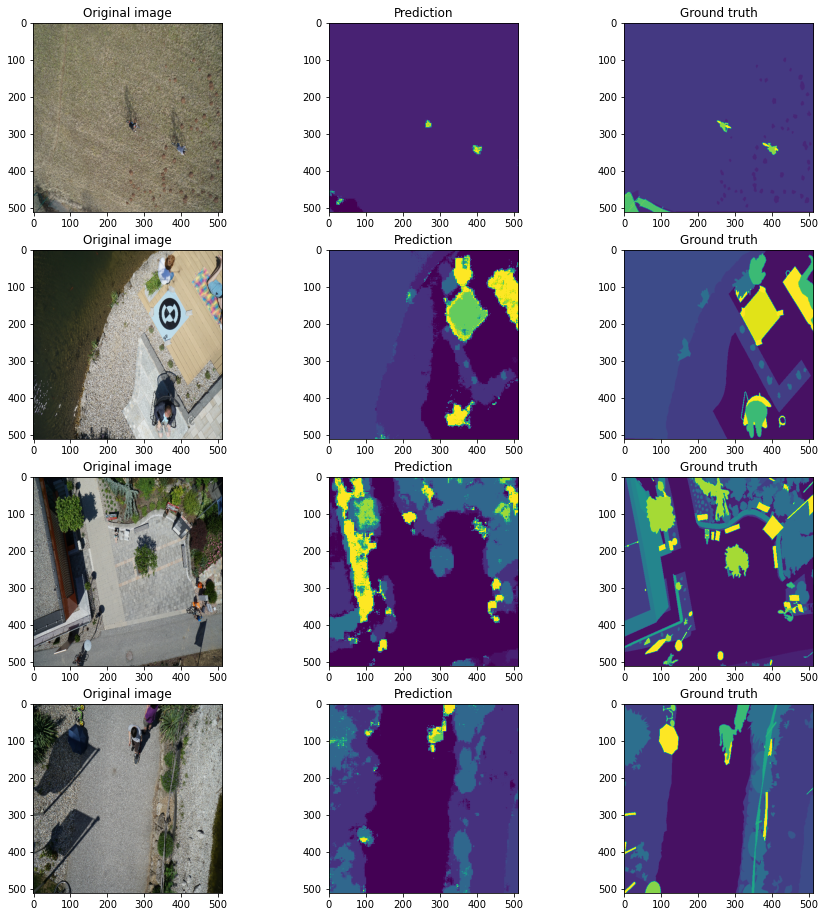

In [25]:
fig, ax = plt.subplots(BATCH_SIZE, 3, figsize=(15, 4 * BATCH_SIZE))
for j in range(BATCH_SIZE):
    ax[j, 0].imshow(images[j, ...].numpy())
    ax[j, 1].imshow(predictions[j, ...].astype('uint8'))
    ax[j, 2].imshow(labels[j, ...])
    ax[j, 0].set_title('Original image')
    ax[j, 1].set_title('Prediction')
    ax[j, 2].set_title('Ground truth')
plt.show()